# Fragment analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import seaborn as sns

from util import SUBPOCKET_COLORS
from util import read_fragment_library, get_fragmented_ligand, draw_fragmented_ligand, most_common_fragments, generate_fingerprints
from util import connections_by_fragment, connections_by_ligand, connections_count_by_ligand
from util import descriptors_by_fragments, fragment_similarity, plot_fragment_similarity

RDKit WARNING: [16:59:31] Enabling RDKit 2019.09.3 jupyter extensions


## Load fragment library

In [3]:
# Path to library folder
PATH_TO_LIB = Path('.') / '..' / 'data' / 'fragment_library'

In [4]:
# Get fragment library by subpocket
fragment_library = read_fragment_library(PATH_TO_LIB)

for subpocket, fragments in fragment_library.items():
    fragments['subpocket'] = subpocket

In [5]:
print(fragment_library.keys())
print(f'Example fragments for subpocket AP:')

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])
Example fragments for subpocket AP:


In [6]:
# Merge all subpockets
fragment_library_concat = pd.concat(fragment_library)
fragment_library_concat.reset_index(drop=True, inplace=True)

In [7]:
fragment_library_concat

,smiles,fragment,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,subpocket
0,Nc1c[nH]c2ncccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,AP
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,"<img data-content=""rdkit/molecule"" src=""data:i...",AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,AP
2,Cc1cc(N)[nH]n1,"<img data-content=""rdkit/molecule"" src=""data:i...",ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,AP
3,Nc1ncc(C=O)s1,"<img data-content=""rdkit/molecule"" src=""data:i...",ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,AP
4,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,"<img data-content=""rdkit/molecule"" src=""data:i...",ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,AP
...,...,...,...,...,...,...,...,...,...,...,...,...
7481,FC(F)F,"<img data-content=""rdkit/molecule"" src=""data:i...",p70S6K,RSK,AGC,4l42,5FI,,A,X-B2 X-B2 X-B2 X-B2 FP,8 8 8 8 na,X
7482,FC(F)F,"<img data-content=""rdkit/molecule"" src=""data:i...",p70S6K,RSK,AGC,4l43,5FI,,A,X-B2 X-B2 X-B2 X-B2 FP,8 8 8 8 na,X
7483,FC(F)F,"<img data-content=""rdkit/molecule"" src=""data:i...",p70S6K,RSK,AGC,4l44,5FI,,A,X-B2 X-B2 X-B2 X-B2 FP,8 8 8 8 na,X
7484,FC(F)F,"<img data-content=""rdkit/molecule"" src=""data:i...",p70S6K,RSK,AGC,4l45,5FI,,A,X-B2 X-B2 X-B2 X-B2 FP,8 8 8 8 na,X


In [8]:
# Remove pool X
fragment_library_concat_wo_x = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()

## Fragment library overview

In [9]:
# Number of fragments in all fragment subpocket pools
n_fragments = fragment_library_concat.shape[0]

# Number of fragments in all fragment subpocket pools except pool X
n_fragments_wo_x = fragment_library_concat_wo_x.shape[0]

print(f'Number of fragments in library: {n_fragments}')
print(f'Number of fragments in library without pool X: {n_fragments_wo_x}')

Number of fragments in library: 7486
Number of fragments in library without pool X: 7201


In [10]:
# Deduplicate these strings in order to get the number of ligands from which the fragments originate
n_original_ligands = fragment_library_concat.groupby(
    ['group', 'complex_pdb', 'ligand_pdb']
).size().shape[0]

print(f'Number of original ligands (from which fragments originate): {n_original_ligands}')

Number of original ligands (from which fragments originate): 2553


## Number of subpockets occupied by a ligand

Ligands can occupy subpocket(s) multiple times. Let's check how often this happens for which subpockets.

In [11]:
n_fragments_per_subpocket_per_ligand = fragment_library_concat_wo_x.groupby(
    ['group', 'complex_pdb', 'ligand_pdb', 'subpocket']
).size()
n_fragments_per_subpocket_per_ligand = n_fragments_per_subpocket_per_ligand.reset_index()
n_fragments_per_subpocket_per_ligand.rename(columns={0: 'n_fragments'}, inplace=True)

How often does a ligand occupy a subpocket mulitple times? And how many times?

In [12]:
n_fragments_per_subpocket_per_ligand.groupby('n_fragments').size()

n_fragments
1    6948
2     125
3       1
dtype: int64

Which subpockets are occupied how often by multiple fragments per ligand?

In [13]:
n_fragments_per_subpocket_per_ligand[
    n_fragments_per_subpocket_per_ligand.n_fragments > 1
].groupby('subpocket').size()

subpocket
AP     8
B1     1
FP    95
GA     2
SE    20
dtype: int64

In order to calculate the number of subpockets a ligand is occupying, it is not of interest how often a subpocket is occupied by a ligand. Thus, we keep only one entry per ligand and subpocket.

In [14]:
n_subpockets_per_ligand = fragment_library_concat_wo_x.groupby(
    ['group', 'complex_pdb', 'ligand_pdb', 'subpocket']
).first().reset_index().groupby(
    ['group', 'complex_pdb', 'ligand_pdb']
).size()

In [15]:
n_subpockets_per_ligand_distribution = pd.concat(
    [
        n_subpockets_per_ligand.value_counts().sort_index().rename('ligand_count'), 
        n_subpockets_per_ligand.value_counts(normalize=True).sort_index().rename('ligand_frequency')*100
    ],
    axis=1
)

In [16]:
print('Number of subpockets per ligand (distribution):')
n_subpockets_per_ligand_distribution

Number of subpockets per ligand (distribution):


,ligand_count,ligand_frequency
1,127,4.974540
2,719,28.162946
3,1350,52.878966
4,327,12.808461
5,29,1.135919
6,1,0.039170


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 8 Text xticklabel objects>)

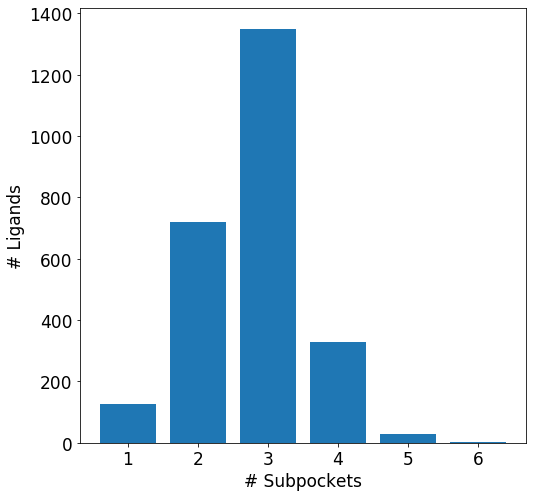

In [17]:
plt.figure(figsize=(8,8))
plt.bar(
    n_subpockets_per_ligand_distribution.index, 
    n_subpockets_per_ligand_distribution.ligand_count
)
plt.ylabel('# Ligands', fontsize=17)
plt.xlabel('# Subpockets', fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

### Examples for ligands occupying 6 subpockets

In [18]:
ligand_of_interest = n_subpockets_per_ligand[n_subpockets_per_ligand == 6].reset_index()
ligand_of_interest

,group,complex_pdb,ligand_pdb,0
0,TK,4fnz,NZF,6


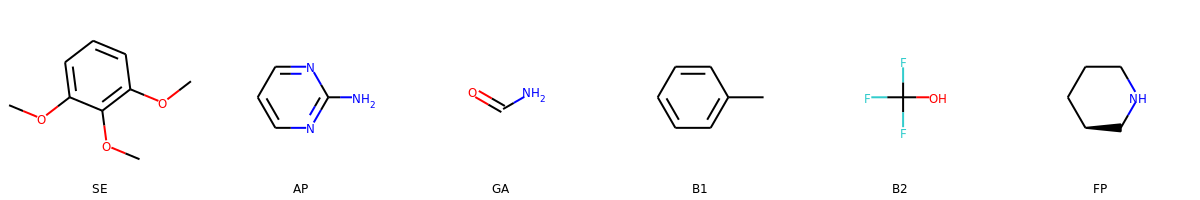

In [19]:
draw_fragmented_ligand(
    fragment_library, 
    ligand_of_interest.complex_pdb.values[0], 
    ligand_of_interest.ligand_pdb.values[0]
)

### Examples for unfragmented ligands

In [20]:
ligand_of_interest = n_subpockets_per_ligand[n_subpockets_per_ligand == 1].reset_index()

In [21]:
unfragmented_ligands = []

for index, row in ligand_of_interest.iterrows():
    
    unfragmented_ligands.append(
        get_fragmented_ligand(
            fragment_library, 
            row.complex_pdb, 
            row.ligand_pdb
        )
    )
    
pd.concat(unfragmented_ligands)

,smiles,fragment,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,subpocket
1903,COc1cc2ncc3c(N)nc4c(C)c(N)ccc4c3c2cc1OC,"<img data-content=""rdkit/molecule"" src=""data:i...",PDK1,PDK1,AGC,2r7b,253,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,3 3 3 3 3 16 16 3 3 3 3 3 16 16 16 16 16 16 16...,AP
1910,Nc1n[nH]c2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",PDK1,PDK1,AGC,3nus,JNZ,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 5 5 5,AP
1911,O=C1NCCc2ccccc21,"<img data-content=""rdkit/molecule"" src=""data:i...",PDK1,PDK1,AGC,3nuu,JOZ,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,na na na na na na na na na na na na na na na n...,AP
1912,Oc1ncnc2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",PDK1,PDK1,AGC,3nuy,JPZ,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 3 3,AP
2080,O=c1[nH]nc(Cl)c2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",PKACa,PKA,AGC,5bx6,495,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,na na na na na na na na na na na na na na na n...,AP
...,...,...,...,...,...,...,...,...,...,...,...,...
1274,Nc1ncc2c(n1)-c1ccccc1[C@H](c1ccccc1)C2,"<img data-content=""rdkit/molecule"" src=""data:i...",FGFR2,FGFR,TK,3ri1,3RH,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 5 5 5 14 14 14 14 14 14 14 14 14 1...,AP
1232,Cc1n[nH]c2c[nH]nc12,"<img data-content=""rdkit/molecule"" src=""data:i...",FAK,FAK,TK,4kab,4KA,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP,14 14 14 14 14 14 14 14 14 14 14 8 8 8 8,AP
235,NC(=O)c1nnc2ccccc2c1N,"<img data-content=""rdkit/molecule"" src=""data:i...",BTK,Tec,TK,4zly,4RU,C,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,5 5 5 14 14 14 14 14 14 14 6 6 14 14 14 14 14 ...,AP
1263,CC1(C)Cc2cccc(C(N)=O)c2O1,"<img data-content=""rdkit/molecule"" src=""data:i...",FGFR1,FGFR,TK,5uq0,WP1,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,13 13 13 13 8 8 8 8 8 8 8 8 13 13 13 13 13 13 ...,AP


## Fragments per subpocket

In [22]:
n_fragments_per_subpocket = [len(fragments) for subpocket, fragments in fragment_library.items()]
n_fragments_per_subpocket_deduplicated = [len(fragments.drop_duplicates('smiles')) for subpocket, fragments in fragment_library.items()]

In [23]:
stats_n_fragments = pd.DataFrame(
    {
        'n_fragments': n_fragments_per_subpocket,
        'n_fragments_deduplicated': n_fragments_per_subpocket_deduplicated,
        'freq_duplicates': [(i-j) / i * 100 for i, j in zip(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)]
    },
    index=fragment_library.keys()
)
stats_n_fragments

,n_fragments,n_fragments_deduplicated,freq_duplicates
AP,2561,1115,56.462319
FP,1866,864,53.697749
SE,1560,607,61.089744
GA,1024,306,70.117188
B1,98,42,57.142857
B2,92,43,53.260870
X,285,110,61.403509


In [24]:
print(f'Mean duplicates frequency across subpockets: {stats_n_fragments.freq_duplicates.mean()}')

Mean duplicates frequency across subpockets: 59.02489073891017


In [25]:
pd.DataFrame(
    {
        'freq_fragments': [i / sum(n_fragments_per_subpocket[:-1]) * 100 for i in n_fragments_per_subpocket[:-1]],
        'freq_fragments_deduplicated': [i / sum(n_fragments_per_subpocket_deduplicated[:-1]) * 100 for i in n_fragments_per_subpocket_deduplicated[:-1]]
    },
    index=list(fragment_library.keys())[:-1]
)

,freq_fragments,freq_fragments_deduplicated
AP,35.564505,37.453813
FP,25.913068,29.022506
SE,21.663658,20.389654
GA,14.220247,10.278804
B1,1.360922,1.410816
B2,1.277600,1.444407


In [26]:
print(f'Number of fragments (wo X): {sum(n_fragments_per_subpocket[:-1])}')
print(f'Number of deduplicated fragments (wo X): {sum(n_fragments_per_subpocket_deduplicated[:-1])}')

Number of fragments (wo X): 7201
Number of deduplicated fragments (wo X): 2977


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text yticklabel objects>)

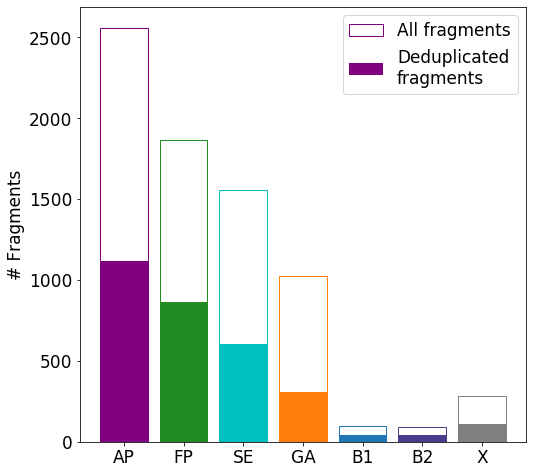

In [27]:
plt.figure(figsize=(8,8))
plt.bar(
    SUBPOCKET_COLORS.keys(), 
    n_fragments_per_subpocket, 
    fill=False, 
    edgecolor=SUBPOCKET_COLORS.values()
)
plt.bar(
    SUBPOCKET_COLORS.keys(), 
    n_fragments_per_subpocket_deduplicated, 
    color=SUBPOCKET_COLORS.values()
)
plt.legend(['All fragments', 'Deduplicated\nfragments'], fontsize=17)
plt.ylabel('# Fragments', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

## Subpocket connections

In [28]:
connections_by_fragment = connections_by_fragment(fragment_library_concat_wo_x)
connections_by_fragment.head()

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name
0,AAK1,5l4q,LKB,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,"[FP, SE]","[AP=FP, AP=SE]"
1,AAK1,5te0,XIN,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, GA]","[AP=SE, AP=GA]"
2,ABL1,2f4j,VX6,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,[SE],[AP=SE]
3,ABL1,2gqg,1N1,AP AP AP AP AP AP AP AP AP AP GA SE,"[GA, SE]","[AP=GA, AP=SE]"
4,ABL1,2v7a,627,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, FP]","[AP=SE, AP=FP]"


In [29]:
connections_by_ligand = connections_by_ligand(fragment_library_concat_wo_x)
connections_by_ligand.head()

group  complex_pdb  ligand_pdb
AGC    1z5m         LI8           {AP=FP, AP=SE}
       2esm         M77                  {AP=FP}
       2etk         HFS                  {AP=FP}
       2etr         Y27                  {AP=FP}
       2gu8         796                  {AP=FP}
Name: connections_name, dtype: object

In [30]:
connections = connections_count_by_ligand(connections_by_ligand)
connections

,count,frequency
AP=FP,1569,61.5
AP=SE,1502,58.8
AP=GA,920,36.0
FP=GA,198,7.8
FP=SE,196,7.7
SE=X-SE,125,4.9
FP=X-B2,99,3.9
B1=GA,94,3.7
B2=GA,84,3.3
FP=X-FP,22,0.9


## Fragment physicochemical properties

In [31]:
properties = descriptors_by_fragments(fragment_library)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 9 Text yticklabel objects>)

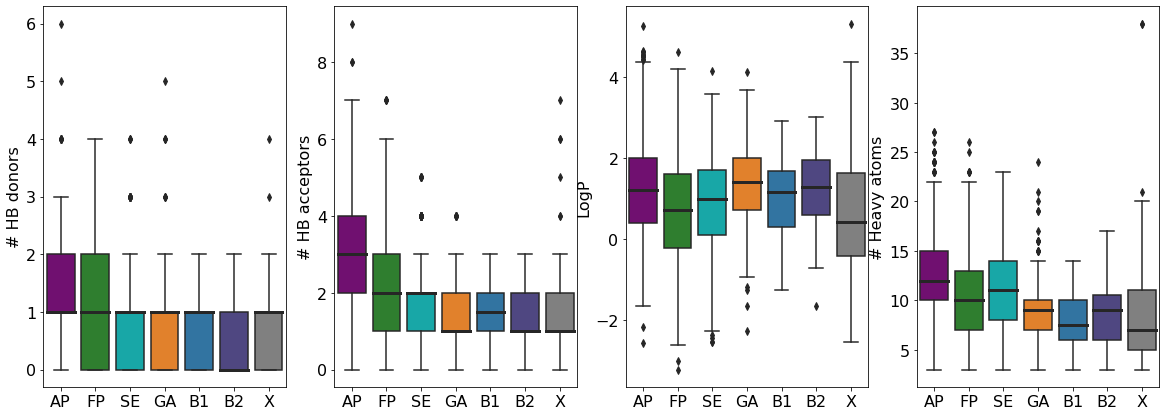

In [32]:
plt.figure(figsize=(20,7))

plt.subplot(141)
sns.boxplot(x='subpocket', y='# HB donors', data=properties, palette=SUBPOCKET_COLORS, medianprops={'linewidth':3, 'linestyle':'-'})
plt.ylabel('# HB donors', fontsize=16)
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(142)
sns.boxplot(x='subpocket', y='# HB acceptors', data=properties, palette=SUBPOCKET_COLORS, medianprops={'linewidth':3, 'linestyle':'-'})
plt.ylabel('# HB acceptors', fontsize=16)
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(143)
sns.boxplot(x='subpocket', y='LogP', data=properties, palette=SUBPOCKET_COLORS, medianprops={'linewidth':3, 'linestyle':'-'})
plt.ylabel('LogP', fontsize=16)
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(144)
sns.boxplot(x='subpocket', y='# Heavy atoms', data=properties, palette=SUBPOCKET_COLORS, medianprops={'linewidth':3, 'linestyle':'-'})
plt.ylabel('# Heavy atoms', fontsize=16)
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Fragment similarity by subpockets

In [33]:
similarities_per_subpocket = fragment_similarity(fragment_library_concat, by='subpocket')
similarities_per_subpocket.head()

,similarity,subpocket
0,0.104987,AP
1,0.108247,AP
2,0.059072,AP
3,0.198225,AP
4,0.170306,AP


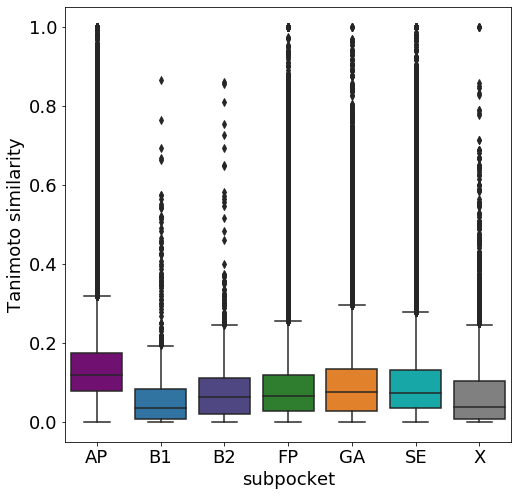

In [34]:
plot_fragment_similarity(similarities_per_subpocket)

In [35]:
similarities_per_subpocket.groupby('subpocket').mean()

,similarity
subpocket,
AP,0.139290
B1,0.074256
B2,0.088506
FP,0.089188
GA,0.104821
SE,0.102719
X,0.077704


## Fragment similarity by kinase group

In [36]:
similarities_per_kinase_group = fragment_similarity(fragment_library_concat, by='group')
similarities_per_kinase_group.head()

,similarity,group
0,0.530864,AGC
1,0.527607,AGC
2,0.464865,AGC
3,0.643411,AGC
4,0.166065,AGC


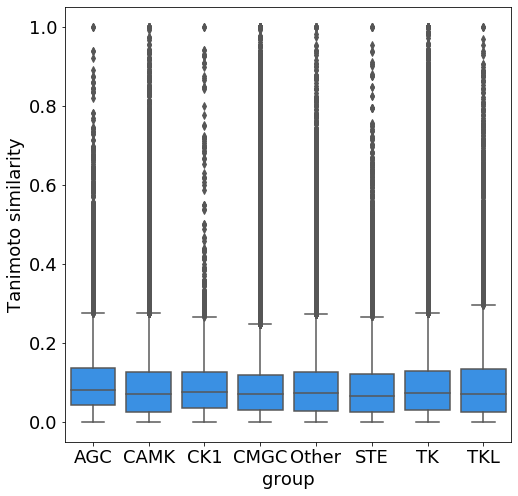

In [37]:
plot_fragment_similarity(similarities_per_kinase_group)